In [1]:
#train an CNN model for the accent detector
#for low tech demo: onlhy destringuish us accents with others 

#import models to be used
import numpy as np
import pandas as pd
import librosa
import multiprocessing
import sys
import os

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras import utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, TensorBoard

from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import utils

from scipy.io import wavfile
from matplotlib import pyplot as plt
import glob 
import librosa.display

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

Using TensorFlow backend.


In [2]:
DEBUG = True
SILENCE_THRESHOLD = .01
RATE = 24000
N_MFCC = 13
COL_SIZE = 30
EPOCHS = 10 #35#250

In [3]:
#get audio data and information from speech accent archive using Webscraping
import os # To interact with operating system and format file name
import shutil # To copy file object from python to disk
import requests
import bs4 as bs 
from collections import Counter
import re
import urllib.request
import sys
from pydub import AudioSegment
#source = requests.get("http://accent.gmu.edu/browse_language.php")
#soup = bs.BeautifulSoup(source.content, features='html.parser') 
#print(soup.prettify())


In [4]:
"""specify desired languages; 
for now (check point #1): only english and mandarin are used;
eventually/ideally, all languages will be used"""
languages = ["mandarin","english"]
URL = 'http://accent.gmu.edu/'
mp3_url = 'http://chnm.gmu.edu/accent/soundtracks/{}.mp3'


In [5]:
#get data and bio information from the url
def create_df(languages = languages, url = URL):
    import bs4 as bs 
    search_url = [url+'browse_language.php?function=find&language={}'.format(l) for l in languages]
    htmls = []
    for url in search_url:
        #print('downloading from {}'.format(url))
        htmls.append(requests.get(url).text)
    #print(htmls)
    
    bss = [bs.BeautifulSoup(html,'html.parser') for html in htmls]
    #print(bss)
    people = []
    counter = 0
    for b in bss:
        
        for p in b.find_all('p'):
            counter += 1
            if p.a:
                text = p.text.replace(' ','').split(',')
                address = 'http://accent.gmu.edu/'+p.a['href']
                speakerid = address.split('speakerid=')[1]
                #print(speakerid)
                s = bs.BeautifulSoup(requests.get(address).text,'html.parser')
                each_bio = [li.text for li in s.find('ul','bio').find_all('li')]
                native_language = each_bio[1].split(': ')[1]
                eng_residence = each_bio[6].split(': ')[1]
                if native_language.find("english") != -1 and eng_residence.find('usa') != -1:
                    if_us_native = 1
                else:
                    if_us_native = 0
                x = [speakerid,address, text[0], text[1],native_language, if_us_native]
                #print(counter)
                #print(x)
                
                people.append(x)
                                
    df = pd.DataFrame(people, columns=['speakerid','href','language_num','gender',\
                                       'native_language','if_us_native'])
    
    return df

In [6]:
df = create_df()

In [7]:
#some helper code scratch
#df.groupby('if_us_native').count()
"""source = bs.BeautifulSoup(requests.get(df['href'][len(df['href'])-1]).text,'html.parser')
each_bio = [li.text for li in source.find('ul','bio').find_all('li')]
each_bio"""
path = os.getcwd()  
print ("The current working directory is %s" % path)

The current working directory is /Users/Ming/Desktop/ind135-sp19-gaide


In [8]:
df.groupby('if_us_native').count()


,speakerid,href,language_num,gender,native_language
if_us_native,,,,,
0,301,301,301,301,301
1,457,457,457,457,457


In [9]:
def get_audio(df,destination_folder,url = mp3_url):
    
    if not os.path.exists(destination_folder):
        print('creating audio destination folder'.format(destination_folder))
        os.makedirs(os.getcwd() + "/" + destination_folder)
    else:
        print('audio destination folder already exists.')
            
    counter = 0
    for lang_num in df['language_num']:
        if not os.path.exists(destination_folder +'{}.wav'.format(lang_num)):
            print('downloading {}'.format(lang_num))
            (filename, headers) = urllib.request.urlretrieve(url.format(lang_num))
            sound = AudioSegment.from_mp3(filename)
            sound.export(os.getcwd() +"/"+ destination_folder + "{}.wav".format(lang_num),\
                         format="wav")
            counter += 1

    return counter

In [10]:
# get_audio(df, 'wav')

In [11]:
#get filenames

filenames = []

for file in df.loc[:, "language_num"]:
    filenames.append("wav/wav" + file + ".wav")
        
label = df.loc[:, "if_us_native"]

d = {'filename': filenames, 'label': label}
train = pd.DataFrame(data=d)

In [14]:
#we extract mfcc feature from data
def extract_feature(file_name):
    try:
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None
    return (mfccs)

feature = []
for i in range(len(filenames)):
    feature.append(extract_feature(filenames[i]))
     

temp = pd.DataFrame({'feature': feature, 'label': label})


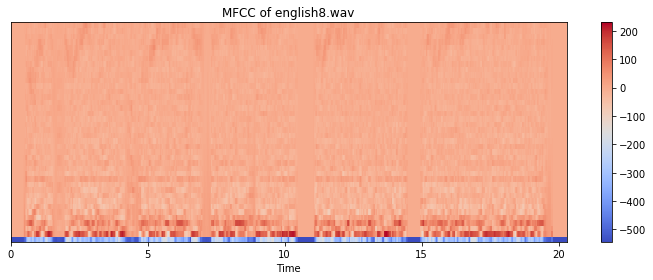

In [15]:
# Sample feature exaction plot

y, sr = librosa.load("wav/wavenglish8.wav", res_type='kaiser_fast') 
mfccs_ = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)


plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_, x_axis='time')
plt.colorbar()
plt.title('MFCC of english8.wav')
plt.tight_layout()

In [ ]:
# prepare data for building model and split data into train data and validation data

X = np.array(temp.feature.tolist())
y = np.array(temp.label.tolist())

lb = LabelEncoder()

y = utils.to_categorical(lb.fit_transform(y))

valX = X[len(X) - 100:]
valY = y[len(y) - 100:]


X = X[0:len(X) - 100]
y = y[0:len(y) - 100]


In [67]:
# build model
labels = y.shape[1]
filter_size = 2


model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [68]:
model.fit(X, y, batch_size=32, epochs=5, validation_data=(valX, valY))

Train on 658 samples, validate on 100 samples
Epoch 1/5
658/658 [==============================] - 1s 1ms/step - loss: 6.0734 - acc: 0.5866 - val_loss: 3.5460 - val_acc: 0.7800
Epoch 2/5
658/658 [==============================] - 0s 110us/step - loss: 6.7258 - acc: 0.5775 - val_loss: 3.5460 - val_acc: 0.7800
Epoch 3/5
658/658 [==============================] - 0s 102us/step - loss: 6.8214 - acc: 0.5729 - val_loss: 3.5460 - val_acc: 0.7800
Epoch 4/5
658/658 [==============================] - 0s 105us/step - loss: 6.8343 - acc: 0.5760 - val_loss: 3.5460 - val_acc: 0.7800
Epoch 5/5
658/658 [==============================] - 0s 110us/step - loss: 6.7626 - acc: 0.5790 - val_loss: 3.5460 - val_acc: 0.7800
